<a href="https://colab.research.google.com/github/jdvala/Thesis/blob/master/Finding_K_in_Kmeans_%26_Constrained_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding K in K Means and Constrained K-means algorithm

In [0]:
# unpickle data
import pickle
def unpickle(obj):
    with open(obj, 'rb') as picklehandle:
        toReturn = pickle.load(picklehandle)
    return toReturn

In [0]:
en_data = unpickle('/content/EN-DATA.pkl')
label = unpickle('/content/EN-LABEL.pkl')

In [0]:
# Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [0]:
tfidf_matrix_constructor = TfidfVectorizer(max_df=0.8, max_features=200000, min_df=0.2, ngram_range=(1,3))

tfidf_matrix = tfidf_matrix_constructor.fit_transform(en_data)

# printing the shape of the resultant matrix to ensure I am right
print(tfidf_matrix.shape)

(3310, 346)


In [0]:
# for silhouette_score the number of clusters should start from 2 and for elbow analysis it should start at 3
for k in range(2 ,9):
    
    # define k-means constructor
    kmeans = KMeans(n_clusters=k,random_state=13)
    
    cluster_labels = kmeans.fit_predict(tfidf_matrix.toarray())
    
    # Calculating silhouette_score for k
    
    score = silhouette_score(tfidf_matrix.toarray(), cluster_labels, random_state=10)
    #_inertia.append(kmeans.inertia_)
    print("The silhouette score for {} clusters is {}".format(k,score))

The silhouette score for 2 clusters is 0.056933935938822865
The silhouette score for 3 clusters is 0.04417673324401779
The silhouette score for 4 clusters is 0.04749507212623459
The silhouette score for 5 clusters is 0.055155238878596496
The silhouette score for 6 clusters is 0.054800906885848655
The silhouette score for 7 clusters is 0.05647847971329182
The silhouette score for 8 clusters is 0.05537725230543471


In [0]:
#Elbow
_inertia = []
for k in range(1 ,9):
    
    # define k-means constructor
    kmeans = KMeans(n_clusters=k,random_state=13)
    
    cluster_labels = kmeans.fit_predict(tfidf_matrix.toarray())
    
    # Calculating silhouette_score for k
    
    #score = silhouette_score(tfidf_matrix.toarray(), cluster_labels, random_state=10)
    _inertia.append(kmeans.inertia_)
    #print("The silhouette score for {} clusters is {}".format(k,score))

The Silhouette score is heighest for 2 cluster

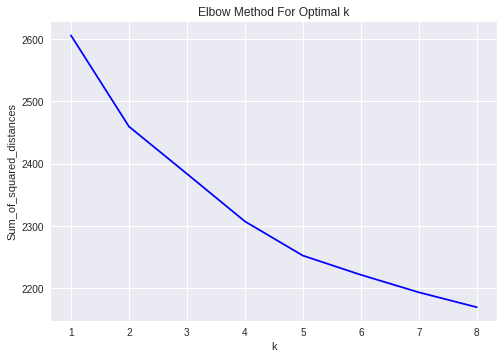

In [0]:
import matplotlib.pyplot as plt
K = range(1,9)
plt.plot(K, _inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [0]:
# Getting Constrains
index = range(0,len(en_data))

tmp_list = []

for i,j in enumerate(label):
    for k,l in enumerate(label):
        if i !=k:
            if j == l:
                tmp_list.append((i,k))

In [0]:
# -*- coding: utf-8 -*-
import random

def cop_kmeans(dataset, k, ml=[], cl=[],
               initialization='kmpp',
               max_iter=300, tol=1e-4):

    ml, cl = transitive_closure(ml, cl, len(dataset))
    ml_info = get_ml_info(ml, dataset)
    tol = tolerance(tol, dataset)

    centers = initialize_centers(dataset, k, initialization)

    for _ in range(max_iter):
        clusters_ = [-1] * len(dataset)
        for i, d in enumerate(dataset):
            indices, _ = closest_clusters(centers, d)
            counter = 0
            if clusters_[i] == -1:
                found_cluster = False
                while (not found_cluster) and counter < len(indices):
                    index = indices[counter]
                    if not violate_constraints(i, index, clusters_, ml, cl):
                        found_cluster = True
                        clusters_[i] = index
                        for j in ml[i]:
                            clusters_[j] = index
                    counter += 1

                if not found_cluster:
                    return None, None

        clusters_, centers_ = compute_centers(clusters_, dataset, k, ml_info)
        shift = sum(l2_distance(centers[i], centers_[i]) for i in range(k))
        if shift <= tol:
            break

        centers = centers_

    return clusters_, centers_

def l2_distance(point1, point2):
    return sum([(float(i)-float(j))**2 for (i, j) in zip(point1, point2)])

# taken from scikit-learn (https://goo.gl/1RYPP5)
def tolerance(tol, dataset):
    n = len(dataset)
    dim = len(dataset[0])
    averages = [sum(dataset[i][d] for i in range(n))/float(n) for d in range(dim)]
    variances = [sum((dataset[i][d]-averages[d])**2 for i in range(n))/float(n) for d in range(dim)]
    return tol * sum(variances) / dim

def closest_clusters(centers, datapoint):
    distances = [l2_distance(center, datapoint) for
                 center in centers]
    return sorted(range(len(distances)), key=lambda x: distances[x]), distances

def initialize_centers(dataset, k, method):
    if method == 'random':
        ids = list(range(len(dataset)))
        random.shuffle(ids)
        return [dataset[i] for i in ids[:k]]

    elif method == 'kmpp':
        chances = [1] * len(dataset)
        centers = []

        for _ in range(k):
            chances = [x/sum(chances) for x in chances]
            r = random.random()
            acc = 0.0
            for index, chance in enumerate(chances):
                if acc + chance >= r:
                    break
                acc += chance
            centers.append(dataset[index])

            for index, point in enumerate(dataset):
                cids, distances = closest_clusters(centers, point)
                chances[index] = distances[cids[0]]

        return centers

def violate_constraints(data_index, cluster_index, clusters, ml, cl):
    for i in ml[data_index]:
        if clusters[i] != -1 and clusters[i] != cluster_index:
            return True

    for i in cl[data_index]:
        if clusters[i] == cluster_index:
            return True

    return False

def compute_centers(clusters, dataset, k, ml_info):
    cluster_ids = set(clusters)
    k_new = len(cluster_ids)
    id_map = dict(zip(cluster_ids, range(k_new)))
    clusters = [id_map[x] for x in clusters]

    dim = len(dataset[0])
    centers = [[0.0] * dim for i in range(k)]

    counts = [0] * k_new
    for j, c in enumerate(clusters):
        for i in range(dim):
            centers[c][i] += dataset[j][i]
        counts[c] += 1

    for j in range(k_new):
        for i in range(dim):
            centers[j][i] = centers[j][i]/float(counts[j])

    if k_new < k:
        ml_groups, ml_scores, ml_centroids = ml_info
        current_scores = [sum(l2_distance(centers[clusters[i]], dataset[i])
                              for i in group)
                          for group in ml_groups]
        group_ids = sorted(range(len(ml_groups)),
                           key=lambda x: current_scores[x] - ml_scores[x],
                           reverse=True)

        for j in range(k-k_new):
            gid = group_ids[j]
            cid = k_new + j
            centers[cid] = ml_centroids[gid]
            for i in ml_groups[gid]:
                clusters[i] = cid

    return clusters, centers

def get_ml_info(ml, dataset):
    flags = [True] * len(dataset)
    groups = []
    for i in range(len(dataset)):
        if not flags[i]: continue
        group = list(ml[i] | {i})
        groups.append(group)
        for j in group:
            flags[j] = False

    dim = len(dataset[0])
    scores = [0.0] * len(groups)
    centroids = [[0.0] * dim for i in range(len(groups))]

    for j, group in enumerate(groups):
        for d in range(dim):
            for i in group:
                centroids[j][d] += dataset[i][d]
            centroids[j][d] /= float(len(group))

    scores = [sum(l2_distance(centroids[j], dataset[i])
                  for i in groups[j])
              for j in range(len(groups))]

    return groups, scores, centroids

def transitive_closure(ml, cl, n):
    ml_graph = dict()
    cl_graph = dict()
    for i in range(n):
        ml_graph[i] = set()
        cl_graph[i] = set()

    def add_both(d, i, j):
        d[i].add(j)
        d[j].add(i)

    for (i, j) in ml:
        add_both(ml_graph, i, j)

    def dfs(i, graph, visited, component):
        visited[i] = True
        for j in graph[i]:
            if not visited[j]:
                dfs(j, graph, visited, component)
        component.append(i)

    visited = [False] * n
    for i in range(n):
        if not visited[i]:
            component = []
            dfs(i, ml_graph, visited, component)
            for x1 in component:
                for x2 in component:
                    if x1 != x2:
                        ml_graph[x1].add(x2)
    for (i, j) in cl:
        add_both(cl_graph, i, j)
        for y in ml_graph[j]:
            add_both(cl_graph, i, y)
        for x in ml_graph[i]:
            add_both(cl_graph, x, j)
            for y in ml_graph[j]:
                add_both(cl_graph, x, y)

    for i in ml_graph:
        for j in ml_graph[i]:
            if j != i and j in cl_graph[i]:
                raise Exception('inconsistent constraints between %d and %d' %(i, j))

    return ml_graph, cl_graph


In [0]:
random.seed(0)
clusters, centers = cop_kmeans(dataset=tfidf_matrix.toarray(), k=2, ml=tmp_list,cl=[])
dict_ = dict(zip(label,clusters))

In [0]:
Counter(clusters)

Counter({0: 1581, 1: 1729})

In [0]:
dict_

{'agriculture': 0,
 'audiovisual_and_media': 0,
 'budget': 1,
 'competition': 0,
 'consumers': 0,
 'culture': 1,
 'customs': 1,
 'development': 1,
 'economic_and_monetary_affairs': 1,
 'education_training_youth': 1,
 'employment_and_social_policy': 0,
 'energy': 0,
 'enlargement': 1,
 'enterprise': 0,
 'environment': 0,
 'external_relations': 1,
 'external_trade': 1,
 'fight_against_fraud': 1,
 'food_safety': 0,
 'foreign_and_security_policy': 1,
 'human_rights': 1,
 'humanitarian_aid': 1,
 'information_society': 0,
 'institutional_affairs': 1,
 'internal_market': 0,
 'justice_freedom_security': 1,
 'maritime_affairs_and_fisheries': 1,
 'public_health': 0,
 'regional_policy': 1,
 'research_innovation': 1,
 'taxation': 0,
 'transport': 0}